In [2]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate

In [9]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [59]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Загрузка данных
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')
edf = pd.read_csv('RZD.csv', sep='\t', encoding='utf-8')

In [28]:
# Датасет отсортированный по станции > номеру вагона > времени операции
ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

In [134]:
ndf.destination_esr.value_counts()

986,103.00    231148
967,808.00    169498
984,700.00     72698
932,207.00     69379
863,007.00     69100
               ...  
247,600.00         1
51,905.00          1
602,209.00         1
829,400.00         1
870,706.00         1
Name: destination_esr, Length: 1972, dtype: int64

### Переменные:

In [168]:
"""
Примеры номеров станций ['operation_st_esr']
"""
# st_id = 889505 # 100 ops, 4 cars
# st_id = 845009 # 90 ops, 28 cars
# st_id = 977000 # 50 ops, 10 cars
# st_id = 985906 # 207037 ops, 43702 cars
# st_id = 925701 # 37386 ops, 3801 cars
st_id = 926206 # 18489 ops, 363 cars
# st_id = 880407
# st_id = 967704 ## << wtf??
# st_id = 881804
# st_id = 986103 ## Top destination 
# st_id = 863007 ## 5th by destination

"""
Примеры номеров вагонов ['car_number']
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712
# car_num = 30870752
# car_num = 42051359
# car_num = 42780155
# car_num = 30061394
# car_num = 55952550
car_num = 55952550

"""
Примеры номеров поездов ['index_train']
"""
train_num = 925701004926206

#######################

# переменная для построения графов
carSet = {car_num}


# проверка соответствия st_id и car_num
def check_st_car(st_id, car_num):
    if ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().index[:10],
                 'Строк': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
            pd.DataFrame(
                {'Станция': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().index,
                 'Строк': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().values}
            )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )


check_st_car(st_id, car_num)
print(f'\nВагон {car_num} также присутствует в записях со следующими поездами: \n\n\
{ndf.index_train[ndf.car_number == car_num].value_counts()}')


Для станции 926206 есть 106 строк(а) по вагону 55952550

Вагон 55952550 также присутствует в записях со следующими поездами: 

925,701,004,926,206.00    4
926,206,001,925,701.00    3
925,701,049,926,206.00    3
926,206,418,925,701.00    3
925,701,089,926,206.00    3
925,701,095,926,206.00    3
925,701,013,926,206.00    3
926,206,432,925,701.00    3
926,206,415,925,701.00    3
925,701,065,926,206.00    3
926,206,945,925,701.00    3
925,701,039,926,206.00    3
926,206,410,925,701.00    3
925,701,054,926,206.00    3
926,206,949,925,701.00    3
925,701,007,926,206.00    3
925,701,082,926,206.00    3
926,206,883,925,701.00    3
925,701,085,926,206.00    3
925,701,017,926,206.00    3
925,701,075,926,206.00    3
926,206,941,925,701.00    3
926,206,004,925,701.00    3
926,206,445,925,701.00    3
926,206,893,925,701.00    3
926,206,441,925,701.00    3
926,206,450,925,701.00    3
925,701,022,926,206.00    3
925,701,032,926,206.00    3
926,206,423,925,701.00    3
926,206,426,925,701.00    3
925,7

In [137]:
def extract_train(index_train):
    lst = []
    for i,j in enumerate(str(index_train)):
        lst.append(j)
        i+=1
    print('Единая Сетевая Разметка, ЕСР:', ''.join(lst[0:6]))
    print('Порядковый номер состава:', ''.join(lst[6:9]))
    print('ЕСР железнодорожной станции назначения поезда:', ''.join(lst[9:16]))

In [138]:
def extract_car(car_number):
    lst = []
    for i,j in enumerate(str(car_number)):
        if i == 0 and j == '2':
            lst.append('крытый')
        elif i == 0 and j == '3':
            lst.append('специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)')
        elif i == 0 and j == '4':
            lst.append('платформы')
        elif i == 0 and j == '5':
            lst.append('означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»')
        elif i == 0 and j == '6':
            lst.append('полувагон')
        elif i == 0 and j == '7':
            lst.append('цистерны')
        elif i == 0 and j == '8':
            lst.append('изотермические')
        elif i == 0 and j == '9':
            lst.append('прочие')
        elif i == 1 and j == '2':
            lst.append('двух осный')
        elif i == 1 and j == '4':
            lst.append('четырех осный')
        elif i == 1 and j == '6':
            lst.append('шести осный')
        elif i == 1 and j == '8':
            lst.append('восьми осный')
        elif i == 1 and j == '12':
            lst.append('двенадцати осный')
        elif i == 1 and j == '16':
            lst.append('шестнадцати осный')
        elif i == 2 and j == '5':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '6':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '7':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '8':
            lst.append('цистерна с объемом котла 75 м3')
        elif i == 2 and j == '9':
            lst.append('цистерна с объемом котла 85,6 м3')
        elif i == 3 and j.isdigit():
            lst.append('номер вагона который был присвоен заводом: {}'.format(j))
        elif i == 4 and j.isdigit():
            lst.append(j)
        elif i == 5 and j.isdigit():
            lst.append(j)
        elif i == 6 and j.isdigit():
            lst.append('имеется ручной тормоз или переходная площадка, код: {}'.format(j))
        elif i == 7 and j.isdigit():
            lst.append('контрольная число вагона: {}'.format(j))
        else:
            continue
    return lst

In [139]:
extract_train(train_num)

Единая Сетевая Разметка, ЕСР: 885100
Порядковый номер состава: 023
ЕСР железнодорожной станции назначения поезда: 888004


In [140]:
extract_car(car_num)

['платформы',
 'двух осный',
 'номер вагона который был присвоен заводом: 5',
 '6',
 '9',
 'имеется ручной тормоз или переходная площадка, код: 3',
 'контрольная число вагона: 7']

### Избавление от пропусков

#### Операции с поездом когда нет данных по операции с вагоном:

In [70]:
for i in ndf.operation_train[ndf.operation_car.isna()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

In [40]:
# все пропуски можно заменить операцией отправления
ndf.operation_car = ndf.operation_car.fillna(2)

#### Предполагаем что если опасность вагона не указана, значит она отсутствует:

In [71]:
ndf.danger = ndf.danger.fillna(0)

### Первичный анализ датасета

<AxesSubplot:>

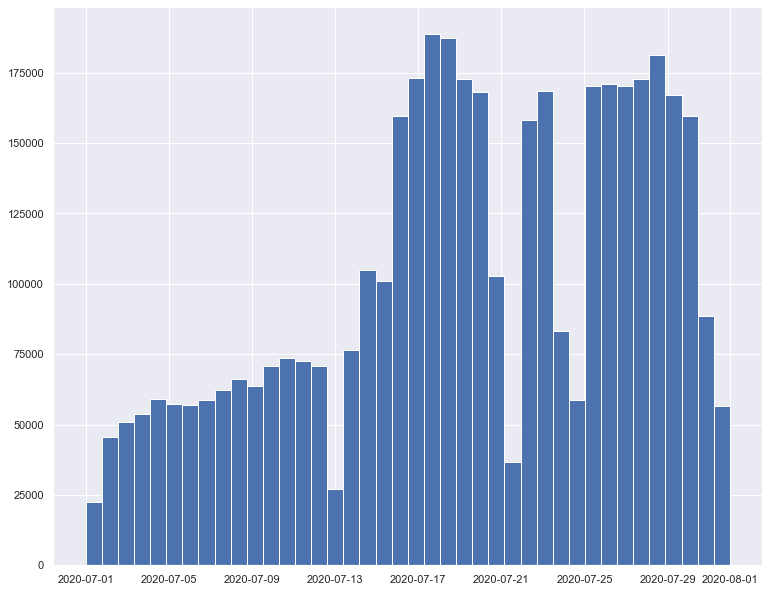

In [222]:
df.operation_date.hist(bins=40)

<AxesSubplot:>

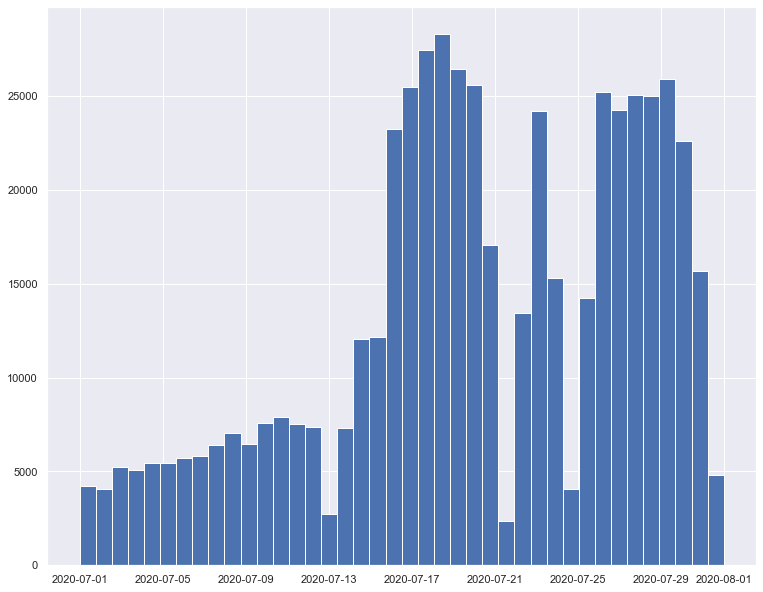

In [224]:
df.operation_date[df.operation_car.isna()].hist(bins=40)

<AxesSubplot:>

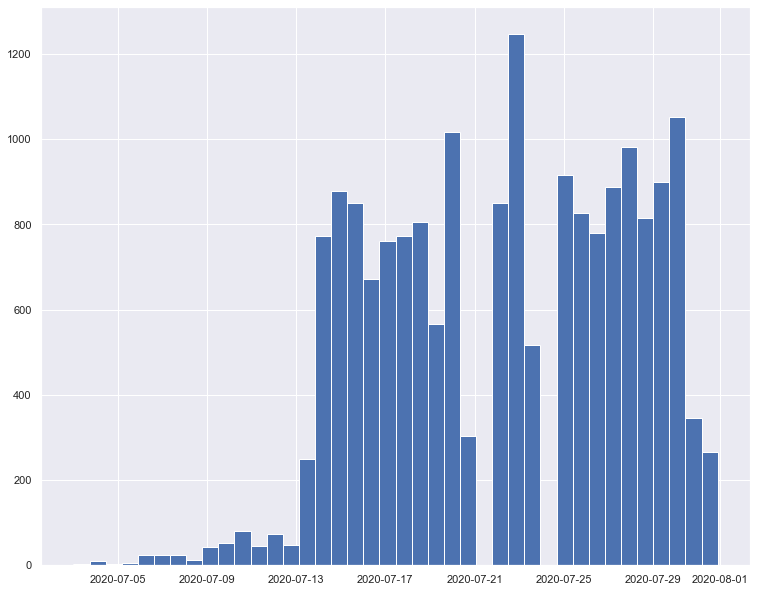

In [225]:
df.operation_date[df.operation_st_esr == st_id].hist(bins=40)

In [141]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

print(f'Количество вагонов которые были отправлены хотя бы один раз:\
 {ndf.car_number[ndf.operation_car == 2].nunique()}')
print(f'В датасете нет данных об отправке\
 {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов\n')

print('Количество операций с вагонами без станции:')
ol = []
for op in list(ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index):
    ol.append(car_ops[car_ops.index_code == op].values[0][1]) 

print(pd.DataFrame(
    {'Шифр': ol,
     'Опер.': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index,
     'Строк': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().values
    }))

Размерность датасета: (4188138, 21)

Временной диапазон:
min: 2020-07-01 00:00:00
max: 2020-07-31 23:59:00

Уникальных станций: 744
Уникальных вагонов: 441248

Количество вагонов которые были отправлены хотя бы один раз: 312835
В датасете нет данных об отправке 128413 уникальных вагонов

Количество операций с вагонами без станции:
    Шифр  Опер.  Строк
0   ИСКП   3.00    123
1   ПВГУ  78.00     61
2   ПГР9  19.00     58
3   ВКЛП   4.00     55
4   ПВПП  80.00     52
5   ОТПР   2.00     49
6   ПГР4  13.00     43
7   ПГР0  18.00     37
8   ВЫГ1  20.00     36
9   УВГУ  79.00     35
10  ВЫГ2  21.00     25
11  УВПП  81.00     14
12  ПГР2  11.00     10


In [73]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4.0 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
80.0 [' ПОДАЧА ВАГОНА НА ПП                  ']
3.0 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
2.0 ['ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
81.0 ['УБОРКА ВАГОНА С ПП                    ']
18.0 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
21.0 ['ВЫГРУЗКА НА ПП                        ']
10.0 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
11.0 ['ПОГРУЗКА НА ПП                        ']
19.0 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
20.0 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
26.0 ['СДАЧА НА ИНОСТРАННУЮ Ж.Д.             ']
78.0 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
79.0 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
28.0 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
16.0 ['ПРИЕМ С ИНОСТРАННОЙ Ж.Д.              ']
27.0 ['ПЕРЕГРУЗ НА УЗКУЮ КОЛЕЮ               ']
13.0 ['ПРИЕМ С ВОДНОГО ТРАНСПОРТА            ']
29.0 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
14.0 ['ПРИЕМ С АВТОТРАНСПОРТА                ']


In [74]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
72.0 ['Отцепка вагонов']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
71.0 ['Прицепка вагонов']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
44.0 ['Подача маршрута под грузовые операции']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
64.0 ['Приб. пассажирского поезда на станцию назначения']
54.0 ['Прекращение "жизни" поезда 3-й категории']
35.0 ['Образование соединенного поезда']


#### Справочные инструменты:

In [75]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        print(f'Операция с вагоном: {car_ops[car_ops.index_code == operation_code].values[0]}')
    except:
        print('NOP')
    try:
        print(f'Операция с поездом: {train_ops[train_ops.index_code == operation_code].values[0]}')
    except:
        print('NOP')
    
get_op_info(3)

Операция с вагоном: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
Операция с поездом: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']


In [142]:
# Выборка станций по количеству записей для станции в датасете:
df.operation_st_id.value_counts()[df.operation_st_id.value_counts() < 400]

# df.operation_st_id.value_counts()

2,000,035,212.00    398
2,000,038,036.00    392
2,001,927,402.00    388
2,001,933,462.00    385
2,000,037,516.00    384
                   ... 
2,000,037,640.00      1
2,000,036,452.00      1
2,000,036,458.00      1
2,000,035,312.00      1
2,000,036,334.00      1
Name: operation_st_id, Length: 283, dtype: int64

In [17]:
# Выборка вагонов по количеству записей для вагона в датасете:
df.car_number.value_counts()[df.car_number.value_counts() == 40]
# df.car_number.value_counts()

60816238    40
30292999    40
30882971    40
68228758    40
53122529    40
            ..
56197015    40
56008337    40
64188410    40
52480720    40
55669386    40
Name: car_number, Length: 357, dtype: int64

### Визуализация датасета

In [148]:
print(f'st_id == {st_id}, в датасете с этой станцией имеются записи по:\n{ndf.car_number[ndf.operation_st_esr == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_esr == st_id].shape[0]} операциям')

st_id == 863007, в датасете с этой станцией имеются записи по:
26287 вагонам и
96307 операциям


Displaing first 800 operations out of 18489


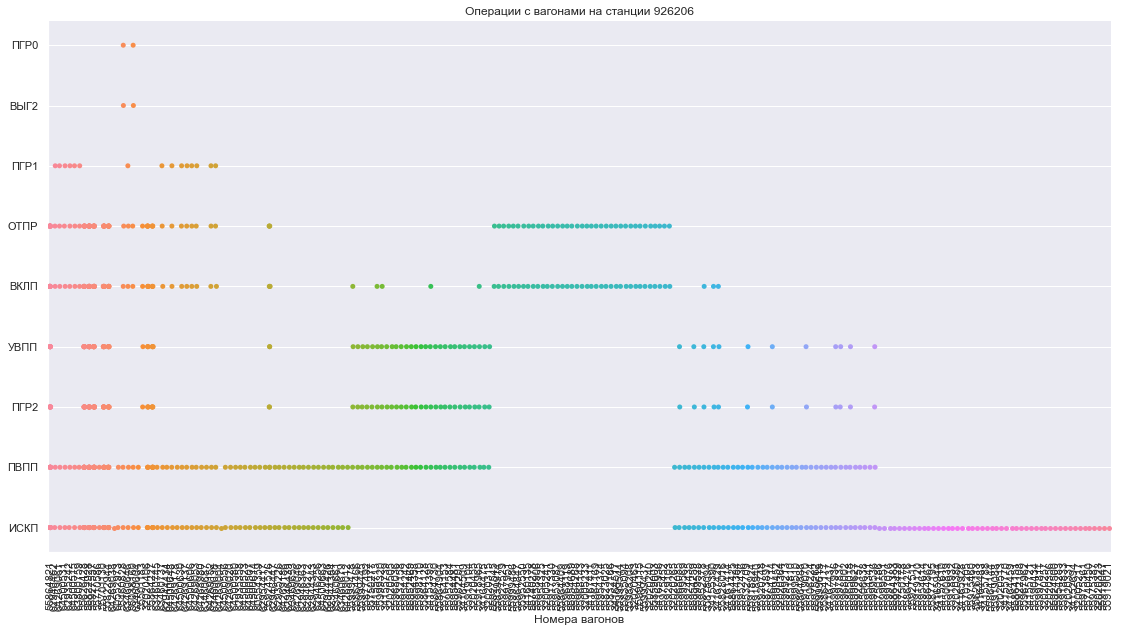

In [170]:
tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
tmp_df = tmp_df[['car_number','operation_car']]
tmp_df.car_number = tmp_df.car_number.apply(lambda x: str(x))
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

if tmp_df.shape[0] > 800:
    print(f"Displaing first 800 operations out of {tmp_df.shape[0]}:")
    tmp_df = tmp_df.loc[:800]


sns.catplot(x=tmp_df['car_number'], y=tmp_df['operation_car'],data=tmp_df,height=8, aspect=4/2)
plt.ylabel('')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
# plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()
# del(tmp_df)

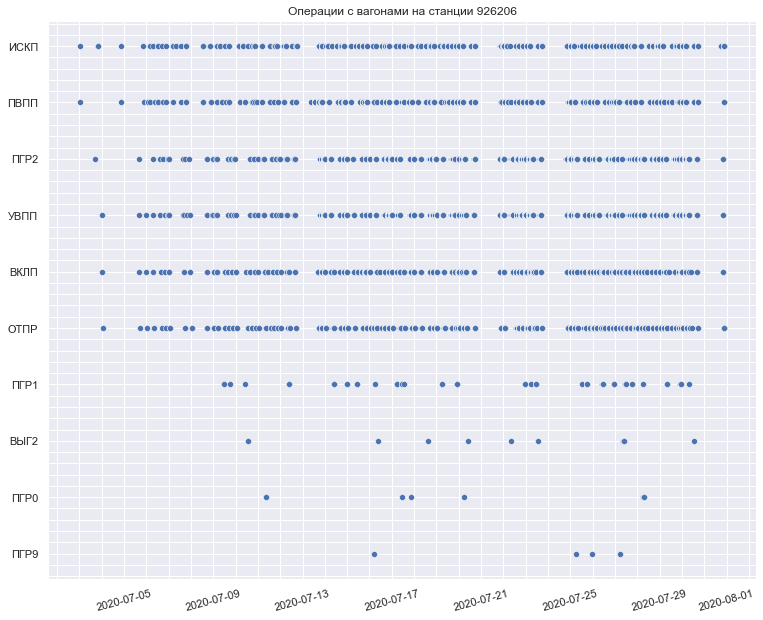

In [171]:
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

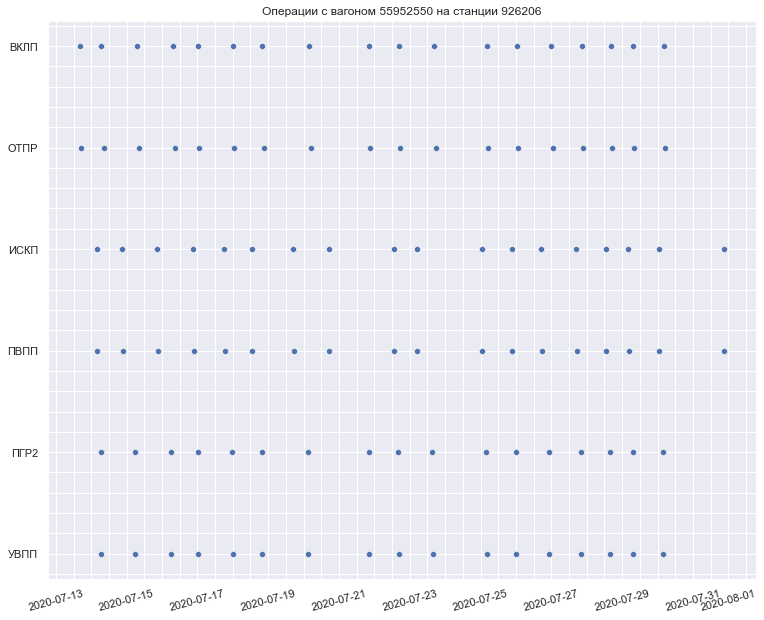

In [173]:
warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_esr == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Отрисовка графов последовательностей операций

In [174]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])

    for cartID in tqdm(cartsSet):
        opsListCart = list(ndf[ndf.car_number == cartID].sort_values(by=['operation_date'])['operation_car'])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

100%|██████████| 1/1 [00:00<00:00, 75.91it/s]


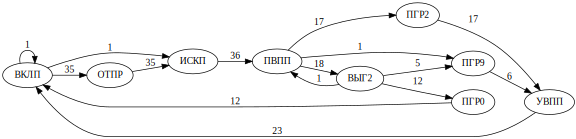

In [175]:
""" Примеры наборов номеров вагонов для отрисовки графов. """

# анализ по одному вагону
carSet = {car_num}

# aнализ по набору вагонов

# анализ по станциям stations
# option A - Показать все цепочки операций по станции
# carSet = set(ndf.car_number[ndf.operation_st_id == st_id])

# option B - выбрать только цепочки длиннее заданного числа
# st = ndf.car_number[ndf.operation_st_id == st_id].value_counts()
# carSet = set(st[st > 2].index)

#####################################

sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG

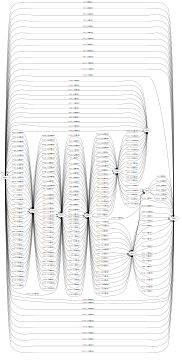

In [176]:
# построить граф переходов между операциями по вагону
# timedelta64[m] - в минутах
# timedelta64[h] - в часах

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # выгрузить в pdf
DG # отобразить граф в ячейке

In [177]:
# cрез датасета по номеру вагона и выбранным полям
ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])[['operation_car','operation_st_esr','destination_esr','ssp_station_esr','index_train']].reset_index(drop=True)

,operation_car,operation_st_esr,destination_esr,ssp_station_esr,index_train
0,4.00,"926,206.00","925,701.00","926,206.00","926,206,001,925,701.00"
1,2.00,"926,206.00","925,701.00","925,701.00","926,206,001,925,701.00"
2,3.00,"925,701.00","925,701.00","925,701.00","926,206,001,925,701.00"
3,80.00,"925,701.00","925,701.00",NaN,NaN
4,21.00,"925,701.00","925,701.00",NaN,NaN
...,...,...,...,...,...
216,18.00,"925,701.00","926,206.00",NaN,NaN
217,4.00,"925,701.00","926,206.00","925,701.00","925,701,099,926,206.00"
218,2.00,"925,701.00","926,206.00","925,701.00","925,701,099,926,206.00"
219,3.00,"926,206.00","926,206.00","926,206.00","925,701,106,926,206.00"


### Анализ цепочек операций

#### Выборка по станции. Словарь с последовательностями операций по вагонам

In [182]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_esr == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_esr == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [183]:
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 363/363 [00:03<00:00, 108.60it/s]


{55822928: '81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80.',
 55952584: '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.',
 55999445: '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 

### Аггрегация вагонов по типовым последовательностям операций

In [184]:
def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [185]:
agg_by_car(cars_ops)

{'81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80.': [55822928],
 '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  4.  2.': [55952584],
 '80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11

In [186]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'3. 80. 11. 81.  4.  2.  3. 80.': 15,
 '3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.': 14,
 '3. 80. 10.  4.  2.': 14,
 '3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.': 11,
 '3. 80. 10.  4.  2.  3. 80.': 11,
 '3. 80.': 10,
 '3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.': 9,
 '3. 80. 10.  4.  4.  2.  3. 80. 10.  4.  2.': 8,
 '3. 80. 10.  4.  2.  3. 80. 10.  4.  2.': 8,
 '3. 80. 10.  4.  2. 10.  4.  2.': 7,
 '4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  3. 80. 11. 81.  4.  2.  

In [187]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)

ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 926206:
[3.0, 80.0, 11.0, 81.0, 4.0, 2.0, 3.0, 80.0]


In [188]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[11 'ПГР2' 'ПОГРУЗКА НА ПП                        ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']


### Формирование датасета

In [43]:
tst = df[1000:60000]

In [119]:
def build_df_for_train(df):
    
    otpr_index = df[df.operation_car.isna()].index
    ops_dict,times_dict = dict.fromkeys(otpr_index),dict.fromkeys(otpr_index)

    for index in tqdm(otpr_index):

        car_num = df.car_number[df.index == index].values[0]
        time_op = df.operation_date[df.index == index].values[0]

        temp_df = df[df.car_number == car_num].copy()
        temp_df = temp_df.sort_values(by=['operation_date'])
        temp_df = temp_df[temp_df.operation_date < time_op]
        temp_df.operation_car = temp_df.operation_car.fillna(2)

        times_list = time_op - temp_df.operation_date[-5:].iloc[::-1].values
        ops_list = temp_df.operation_car[-5:].iloc[::-1].values

        times_dict[index] = times_list
        ops_dict[index] = ops_list
    
    df1 = pd.DataFrame.from_dict(times_dict,orient='index',columns=['minus1-time','minus2-time','minus3-time','minus4-time','minus5-time'])
    df2 = pd.DataFrame.from_dict(ops_dict,orient='index',columns=['minus1-op','minus2-op','minus3-op','minus4-op','minus5-op'])
    
    return pd.concat([df.loc[otpr_index],df2, df1], axis=1)

In [120]:
zzz = build_df_for_train(tst)

100%|██████████| 22853/22853 [00:52<00:00, 435.05it/s]


In [121]:
zzz

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto,minus1-op,minus2-op,minus3-op,minus4-op,minus5-op,minus1-time,minus2-time,minus3-time,minus4-time,minus5-time
19087,864103871850007.00,1.05,90274879,883809.00,NaN,NaN,421034.00,NaN,NaN,2020-07-16 18:58:00,864103.00,2001930814.00,2.00,5785164.00,92.00,20.00,5785276.00,850007.00,2001930698.00,NaN,2208.00,4.00,18.00,NaN,NaN,NaN,0 days 01:12:00,0 days 03:07:00,NaT,NaT,NaT
19088,864103871850007.00,1.03,90262445,883809.00,NaN,NaN,421034.00,NaN,NaN,2020-07-16 18:58:00,864103.00,2001930814.00,2.00,5785164.00,92.00,20.00,5785276.00,850007.00,2001930698.00,NaN,2208.00,4.00,18.00,NaN,NaN,NaN,0 days 01:12:00,0 days 03:07:00,NaT,NaT,NaT
19089,864103871850007.00,1.05,90280249,883809.00,NaN,NaN,421034.00,NaN,NaN,2020-07-16 18:58:00,864103.00,2001930814.00,2.00,5785164.00,92.00,20.00,5785276.00,850007.00,2001930698.00,NaN,2208.00,4.00,18.00,NaN,NaN,NaN,0 days 01:12:00,0 days 03:05:00,NaT,NaT,NaT
19090,864103871850007.00,1.05,90280223,883809.00,NaN,NaN,421034.00,NaN,NaN,2020-07-16 18:58:00,864103.00,2001930814.00,2.00,5785164.00,92.00,20.00,5785276.00,850007.00,2001930698.00,NaN,2208.00,4.00,18.00,NaN,NaN,NaN,0 days 01:12:00,0 days 03:06:00,NaT,NaT,NaT
19091,864103871850007.00,1.03,90260019,883809.00,NaN,NaN,421034.00,NaN,NaN,2020-07-16 18:58:00,864103.00,2001930814.00,2.00,5785164.00,92.00,20.00,5785276.00,850007.00,2001930698.00,NaN,2208.00,4.00,18.00,NaN,NaN,NaN,0 days 01:12:00,0 days 03:05:00,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,962804567961407.00,1.00,52879384,918206.00,NaN,NaN,235073.00,NaN,NaN,2020-07-16 06:43:00,962109.00,2000038414.00,2.00,89444155.00,60.00,30.00,97768564.00,961407.00,2000038402.00,NaN,1937.00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT
59996,836601092836103.00,1.06,44600856,836103.00,NaN,NaN,316073.00,NaN,NaN,2020-07-16 07:18:00,836601.00,2001930598.00,2.00,1090933.00,40.00,72.00,1090933.00,836103.00,2001930592.00,NaN,64.00,2.00,NaN,NaN,NaN,NaN,0 days 08:36:00,NaT,NaT,NaT,NaT
59997,893106922852002.00,1.00,68088350,852002.00,NaN,NaN,161096.00,NaN,NaN,2020-07-16 07:10:00,893106.00,2000035966.00,2.00,73116035.00,60.00,10.00,81213597.00,893106.00,2000035966.00,NaN,6254.00,4.00,81.00,11.00,NaN,NaN,0 days 01:38:00,0 days 01:40:00,0 days 01:53:00,NaT,NaT
59998,893106922852002.00,1.00,68083187,852002.00,NaN,NaN,161096.00,NaN,NaN,2020-07-16 07:10:00,893106.00,2000035966.00,2.00,73116035.00,60.00,10.00,81213597.00,893106.00,2000035966.00,NaN,6254.00,4.00,81.00,11.00,NaN,NaN,0 days 01:38:00,0 days 01:40:00,0 days 01:53:00,NaT,NaT


## Черновик:

### Профайлер

In [ ]:
## profiler code
# dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
# profile = ProfileReport(ndf, title=dt, explorative=True)
# fname = 'pd-report.html'
# profile.to_file(output_file=fname)

### Проверка гипотез

In [52]:
alex = ops_tr_for_set_of_carts(set(ndf.car_number[ndf.operation_car == 2].values))

100%|██████████| 312835/312835 [1:25:46<00:00, 60.79it/s]


In [60]:
list(alex['from'][alex.to == 2].unique())

[4.0, 2.0, 26.0, 21.0, 18.0, 11.0, 80.0, 3.0, 10.0, 81.0, 19.0, 79.0, 28.0]

In [196]:
ndf[ndf.operation_car == 2].head()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
4,"880,407,949,880,106.00",1.38,29068855,"893,500.00",NaN,0.00,"521,016.00",NaN,2.00,2020-07-23 00:03:00,"880,407.00","2,000,035,090.00",2.00,"91,860,990.00",20.00,72.00,"33,977,721.00","880,106.00","2,000,035,130.00",NaN,240.00
11,"880,407,750,880,801.00",1.06,44411262,"880,801.00",NaN,0.00,NaN,NaN,2.00,2020-07-20 12:30:00,"880,407.00","2,000,035,090.00",2.00,"1,091,476.00",40.00,82.00,"1,091,476.00","880,801.00","2,000,035,162.00",NaN,21.00
14,"880,407,949,880,106.00",1.11,52071826,"890,108.00",NaN,0.00,"521,016.00",NaN,2.00,2020-07-23 00:03:00,"880,407.00","2,000,035,090.00",2.00,"5,785,218.00",20.00,72.00,"56,738,657.00","880,106.00","2,000,035,130.00",NaN,240.00
18,"880,407,001,880,106.00",1.22,52662103,"874,302.00",NaN,0.00,"521,016.00",NaN,2.00,2020-07-27 22:51:00,"880,407.00","2,000,035,090.00",2.00,"36,308,593.00",20.00,72.00,"9,202,573.00","880,106.00","2,000,035,130.00",NaN,147.00
22,"880,407,001,880,106.00",1.22,52662129,"874,302.00",NaN,0.00,"521,016.00",NaN,2.00,2020-07-27 22:51:00,"880,407.00","2,000,035,090.00",2.00,"36,308,593.00",20.00,72.00,"9,202,573.00","880,106.00","2,000,035,130.00",NaN,147.00


Список операций перед операцией 2 по всем вагонам датасета:  
[4.0, 2.0, 26.0, 21.0, 18.0, 11.0, 80.0, 3.0, 10.0, 81.0, 19.0, 79.0, 28.0]  

[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']  
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']  
[26 'СДЧИ' 'СДАЧА НА ИНОСТРАННУЮ Ж.Д.             ']  
[21 'ВЫГ2' 'ВЫГРУЗКА НА ПП                        ']  
[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']  
[11 'ПГР2' 'ПОГРУЗКА НА ПП                        ']  
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']  
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']  
[10 'ПГР1' 'ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']  
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']  
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']  
[79 'УВГУ' ' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']  
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']  

4.00&nbsp;     532309  
26.00&nbsp;      4874  
2.00&nbsp;       2082  
18.00&nbsp;        22  
3.00&nbsp;         15  
80.00&nbsp;        10  
21.00&nbsp;         7  
81.00&nbsp;         6  
10.00&nbsp;         5  
11.00&nbsp;         4  
19.00&nbsp;         4  
79.00&nbsp;         1  
28.00&nbsp;         1  

Dataset attempt